In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import random
import pandas as pd

In [8]:
def ode_demo(y,t,b,g,m):
    """
    Differential equation of a SIR model with equal birth and deathrate.
    
    Arguments:
    y -- 
    t -- time index (days)
    b -- beta parameter (infectiousness)
    g -- gamma parameter (recovery rate)
    m -- mu parameter (birth and deathrate)
    """
    s,i,r = y
    dsdt = m - b * s * i - m * s
    didt = b * s * i - g * i - m * i
    drdt = g * i - m * r
    
    return dsdt, didt, drdt

def SIR_demo(n, max_t, beta, gamma, mu):
  S = [0.99*n]
  I = [0.01*n]
  R = [0]
  t = [0]

  while t[-1] < max_t:
    # Set rates
    rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
            mu * I[-1], gamma * I[-1],  # rate(I)
            mu * R[-1]]  # rate(R)
    
    rates_sum = sum(rates)
    dt = -1*np.log(np.random.random()) / rates_sum
    t.append(t[-1] + dt)
    
    rand = np.random.random()
    
    # Death S
    if rand * rates_sum < rates[0]:
        S.append(S[-1] - 1 + 1)
        I.append(I[-1])
        R.append(R[-1])
    
    # Infection
    elif rand * rates_sum > rates[0] and rand * rates_sum < sum(rates[:2]):
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])
        
    # Death I
    elif rand * rates_sum > sum(rates[:2]) and rand * rates_sum < sum(rates[:3]):
        S.append(S[-1] + 1)
        I.append(I[-1] - 1)
        R.append(R[-1])
    
    # Recovered
    elif rand * rates_sum > sum(rates[:3]) and rand * rates_sum < sum(rates[:4]):
        S.append(S[-1])
        I.append(I[-1] - 1)
        R.append(R[-1] + 1)
    
    # Death R
    elif rand * rates_sum > sum(rates[:4]) and rand * rates_sum < sum(rates[:5]):
        S.append(S[-1] + 1)
        I.append(I[-1])
        R.append(R[-1] - 1)

  return S, I, R, t



def SIR_import(n, max_t, beta, gamma, mu, epsilon):
  S = [n]
  I = [0]
  R = [0]
  t = [0]
  extinctions = 0

  while t[-1] < max_t:
    # Set rates
    rates = [mu * S[-1], beta * S[-1] * I[-1] / n,  # rate(S)
            mu * I[-1], gamma * I[-1],  # rate(I)
            mu * R[-1],  # rate(R)
            epsilon * S[-1]] # Import
    
    rates_sum = sum(rates)
    dt = -1*np.log(np.random.random()) / rates_sum
    t.append(t[-1] + dt)
    
    rand = np.random.random()
    
    # Death S
    if rand * rates_sum < rates[0]:
        S.append(S[-1] - 1 + 1)
        I.append(I[-1])
        R.append(R[-1])
    
    # Infection
    elif rand * rates_sum > rates[0] and rand * rates_sum < sum(rates[:2]):
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])
        
    # Death I
    elif rand * rates_sum > sum(rates[:2]) and rand * rates_sum < sum(rates[:3]):
        S.append(S[-1] + 1)
        I.append(I[-1] - 1)
        R.append(R[-1])

        # Extinctions
        if I[-1] < 1:
          extinctions += 1
    
    # Recovered
    elif rand * rates_sum > sum(rates[:3]) and rand * rates_sum < sum(rates[:4]):
        S.append(S[-1])
        I.append(I[-1] - 1)
        R.append(R[-1] + 1)
        
        # Extinctions
        if I[-1] < 1:
          extinctions += 1
    
    # Death R
    elif rand * rates_sum > sum(rates[:4]) and rand * rates_sum < sum(rates[:5]):
        S.append(S[-1] + 1)
        I.append(I[-1])
        R.append(R[-1] - 1)

    # Import
    elif rand * rates_sum > sum(rates[:5]) and rand * rates_sum < rates_sum:
        S.append(S[-1] - 1)
        I.append(I[-1] + 1)
        R.append(R[-1])

  return S, I, R, t, extinctions

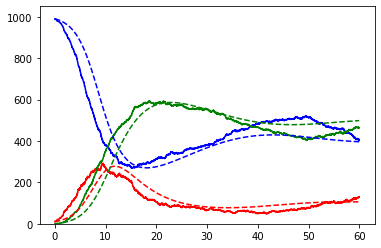

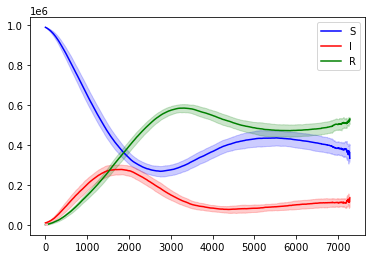

In [20]:
beta = 0.75
gamma = 0.25
mu = 0.05
population = 1000
max_t = 60

s, i, r, t = SIR_demo(population, max_t, beta, gamma, mu)

# Integrate ODE using odeint
time = np.linspace(0, max_t, max_t*2)
y0 = 0.99, 0.01, 0
integrated = odeint(ode_demo, y0, time, args=(beta, gamma, mu))
s_ode, i_ode, r_ode = integrated.T

plt.figure()
plt.plot(t, s, color='b')
plt.plot(t, i, color='r')
plt.plot(t, r, color='g')
plt.plot(time, s_ode*population, color='b', linestyle='--')
plt.plot(time, i_ode*population, color='r', linestyle='--')
plt.plot(time, r_ode*population, color='g', linestyle='--')
plt.ylim(0,population + 50)
plt.show()


for i in range(100):
    S, I, R, T = SIR_demo(population, max_t, beta, gamma, mu)
    if i == 0:
        data_S = {'Srun0': S}
        data_I = {'Irun0': I}
        data_R = {'Rrun0': R}
        dfS = pd.DataFrame(data_S)
        dfI = pd.DataFrame(data_I)
        dfR = pd.DataFrame(data_R)
    elif i != 0:
        temp_dfS = pd.DataFrame({f'Srun{i}': S})
        dfS = pd.concat([dfS, temp_dfS], axis=1)
        temp_dfI = pd.DataFrame({f'Irun{i}': I})
        dfI = pd.concat([dfI, temp_dfI], axis=1)
        temp_dfR = pd.DataFrame({f'Rrun{i}': R})
        dfR = pd.concat([dfR, temp_dfR], axis=1)

meanS = dfS.mean(axis=1, skipna=True)*population
stdS = dfS.std(axis=1, skipna=True)*population
meanI = dfI.mean(axis=1, skipna=True)*population
stdI = dfI.std(axis=1, skipna=True)*population
meanR = dfR.mean(axis=1, skipna=True)*population
stdR = dfR.std(axis=1, skipna=True)*population

plt.figure()
plt.plot(meanS, label='S', color='b')
plt.plot(meanI, label='I', color='r')
plt.plot(meanR, label='R', color='g')
plt.plot(time, s_ode*population, color='pink', linestyle='--')
plt.plot(time, i_ode*population, color='pink', linestyle='--')
plt.plot(time, r_ode*population, color='pink', linestyle='--')

plt.fill_between(np.arange(0, len(meanS)), meanS - stdS, meanS + stdS,
                      color='b', alpha=0.2)
plt.fill_between(np.arange(0, len(meanI)), meanI - stdI, meanI + stdI,
                      color='red', alpha=0.2)
plt.fill_between(np.arange(0, len(meanR)), meanR - stdR, meanR + stdR,
                      color='g', alpha=0.2)

plt.legend(loc=1)
plt.show()

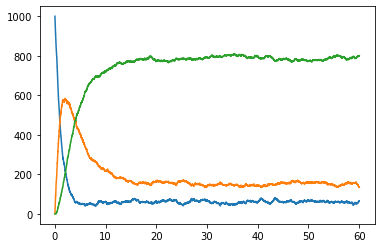

In [10]:
beta = 0.75
gamma = 0.25
mu = 0.05
population = 1000
max_t = 60
epsilon = 0.02 * np.sqrt(population)

s, i, r, t, e = SIR_import(population, max_t, beta, gamma, mu, epsilon)

plt.figure()
plt.plot(t, s)
plt.plot(t, i)
plt.plot(t, r)
plt.show()